In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt


In [2]:
def load_data_label(feature_path, label_file_path):
    label_matrix = pd.read_excel(label_file_path, header=0).drop(['Number','TARGET'],axis=1)
    # Load the data from each file and concatenate into a single feature matrix
    feature_matrix = None

    for i in range(1, len(label_matrix) + 1):
        if i < 10:
          i = '00' + str(i)
        elif i < 100:
          i = '0' + str(i)

        file_path = os.path.join(feature_path, str(i) + ".mp3.npy")
        # print("Processed file " + file_path)
        data = np.load(file_path)
        data = [np.expand_dims(data, axis=-1)]
        if feature_matrix is None:
            feature_matrix = data
        else:
            feature_matrix = np.concatenate((feature_matrix, data), axis=0)
    return feature_matrix, label_matrix


In [15]:
## File parameter
FOLDER_PATH = '/content/drive/MyDrive/music-retrival'
TRAIN_DATA = FOLDER_PATH+ "/data-emotion/set1/spectograms_313x149_Mel_func/"
LABEL_DATA = FOLDER_PATH + "/data-emotion/set1/mean_ratings_set1.xls"

TEST_DATA = FOLDER_PATH+ "/data-emotion/set2/spectograms_313x149_Mel_func/"
EVAL_DATA = FOLDER_PATH + "/data-emotion/set2/mean_ratings_set2.xls"


MODEL_PATH = FOLDER_PATH + '/model/mid2e/'
## DATA PARAMETER
NUM_INSTANCE = 360
TEST_SIZE = 0.2

## Model Parameter
BATCH_SIZE = 8
EPOCHS = 40
MODEL_SAVE = True

In [4]:
pretrained_model = keras.models.load_model(FOLDER_PATH+"/model/" + "/mel-model-4000s/trans-model") #mel-model/ trans-model

In [5]:
 # load feature, label
feature_matrix, label_matrix = load_data_label(TRAIN_DATA, LABEL_DATA)

feature_matrix = pretrained_model.predict(feature_matrix)

feature_matrix = pd.DataFrame(feature_matrix)
# split train, test
# train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix, label_matrix, test_size=TEST_SIZE, random_state=42)

12/12 [==============================] - 46s 4s/step


In [7]:
train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix, label_matrix, test_size=TEST_SIZE, random_state=42)

## Linear Scikit Learn

In [ ]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

# Fit the model to the data
reg.fit(train_features, train_labels)

if MODEL_SAVE == True:
  import pickle
  pickle.dump(reg, open(MODEL_PATH + 'reg_mid2e', 'wb'))

LinearRegression()

In [ ]:
y_pred = reg.predict(test_features)
y_test = test_labels

,valence,energy,tension,anger,fear,happy,sad,tender
224,1.8000,5.0000,5.8000,2.1667,5.1667,1.0000,1.3333,1.0000
42,5.0000,2.6000,3.2000,1.0000,1.0000,1.0000,6.0000,5.1667
285,3.1667,2.3333,3.6667,1.0000,3.2000,1.0000,3.6000,3.6000
302,1.0000,4.6667,7.0000,5.2000,4.8000,1.0000,1.8000,1.0000
56,5.4000,1.8000,3.2000,1.0000,1.6667,2.3333,3.0000,4.8333
...,...,...,...,...,...,...,...,...
199,5.5000,2.8333,3.6667,1.0000,1.0000,1.8000,4.0000,6.0000
334,6.8000,2.8000,1.6000,1.0000,1.0000,4.6667,1.0000,7.8333
93,1.0000,5.2000,6.6000,2.5000,6.6667,1.0000,1.0000,1.0000
198,5.5000,5.1667,3.5000,1.0000,1.4000,5.2000,1.0000,1.4000


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)

# Compute the R-squared value
r2 = r2_score(y_test, y_pred)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print('Mean squared error: {:.2f}'.format(mse))
print('R-squared value: {:.2f}'.format(r2))
print('Mean absolute error: {:.2f}'.format(mae))

y_pred = pd.DataFrame(y_pred)
y_pred.columns = y_test.columns.values

cor_df = dict()
print('-------------------------------')
for i in y_test.columns.values:
  corr_coef = round(np.corrcoef(y_test[i], y_pred[i])[0, 1], 2)
  if 'Emotion' not in cor_df:
    cor_df['Emotion'] = [i]
    cor_df['Correlation'] = [corr_coef]
  else:
    cor_df['Emotion'] += [i]
    cor_df['Correlation'] += [corr_coef]
cor_df = pd.DataFrame(cor_df)
cor_df

Mean squared error: 1.83
R-squared value: 0.49
Mean absolute error: 1.06
-------------------------------


,Emotion,Correlation
0,valence,0.79
1,energy,0.74
2,tension,0.80
3,anger,0.78
4,fear,0.76
5,happy,0.64
6,sad,0.43
7,tender,0.65


In [ ]:
y_pred.describe()

,valence,energy,tension,anger,fear,happy,sad,tender
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,4.226355,3.979601,4.082104,2.209876,2.739524,2.367504,2.528043,2.760228
std,1.334550,1.078196,1.418197,1.437612,1.711292,1.289283,0.939057,1.414498
min,1.289571,2.095067,1.495722,-0.298324,-0.951859,-0.431547,0.129283,-0.329311
25%,3.227338,3.214584,3.044064,1.172329,1.471540,1.479147,1.976503,1.772261
50%,4.389613,3.749372,3.781332,2.085220,2.484922,2.308854,2.791608,3.149776
75%,5.265843,4.596504,5.156246,3.130636,4.098683,3.287672,3.189482,3.828438
max,6.902328,6.914399,7.070066,5.689419,6.370787,5.592233,3.982122,5.232814


## Tensor Linear 

In [13]:
train_features = np.asarray(train_features).astype(float)
train_labels_arr = np.asarray(train_labels).astype(float)

def relu_with_min(output):
    return tf.keras.backend.maximum(output, 1)

normalization_layer = layers.Normalization()
normalization_layer.adapt(train_features)

opt = keras.optimizers.Adam(learning_rate=0.01)

model = tf.keras.models.Sequential([
    normalization_layer,
    tf.keras.layers.Dense(8, activation=relu_with_min),
    # tf.keras.layers.Dense(8),
])

# Compile the model
model.compile(optimizer=opt, loss='MSE',  metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae', 'mape', 'accuracy'])

history = model.fit(train_features, train_labels_arr, epochs=100, validation_data=(test_features, test_labels), batch_size=BATCH_SIZE)

Epoch 1/100
36/36 [==============================] - 1s 16ms/step - loss: 8.1298 - root_mean_squared_error: 2.8513 - mae: 2.0833 - mape: 50.3831 - accuracy: 0.1528 - val_loss: 7.4074 - val_root_mean_squared_error: 2.7217 - val_mae: 1.9925 - val_mape: 49.9703 - val_accuracy: 0.1806
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 7.1149 - root_mean_squared_error: 2.6674 - mae: 1.9090 - mape: 46.3367 - accuracy: 0.2326 - val_loss: 6.4238 - val_root_mean_squared_error: 2.5345 - val_mae: 1.8062 - val_mape: 46.5842 - val_accuracy: 0.2083
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 6.3234 - root_mean_squared_error: 2.5146 - mae: 1.7815 - mape: 45.2090 - accuracy: 0.2535 - val_loss: 5.8360 - val_root_mean_squared_error: 2.4158 - val_mae: 1.7099 - val_mape: 45.0402 - val_accuracy: 0.2500
Epoch 4/100
36/36 [==============================] - 0s 8ms/step - loss: 5.8540 - root_mean_squared_error: 2.4195 - mae: 1.7018 - mape: 44.0950 - accuracy: 

In [ ]:
print('Mid level:', y_test.columns.values )
print('Value:',  )

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('Model loss')
# ax1.ylabel('loss')
# ax1.xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax1.set(xlabel='epoch', ylabel='loss')

ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.set_title('Metric RMSE')
# ax2.ylabel('loss')
# ax2.xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')
ax2.set(xlabel='epoch', ylabel='loss')

fig.tight_layout()

In [16]:
if MODEL_SAVE == True:
  model.save(MODEL_PATH+"cnn_M2E_trans")

In [ ]:
y_pred = model.predict(test_features)
y_test = test_labels

3/3 [==============================] - 0s 6ms/step


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)

# Compute the R-squared value
r2 = r2_score(y_test, y_pred)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print('Mean squared error: {:.2f}'.format(mse))
print('R-squared value: {:.2f}'.format(r2))
print('Mean absolute error: {:.2f}'.format(mae))

y_pred = pd.DataFrame(y_pred)
y_pred.columns = y_test.columns.values

cor_df = dict()
print('-------------------------------')
for i in y_test.columns.values:
  corr_coef = round(np.corrcoef(y_test[i], y_pred[i])[0, 1], 2)
  if 'Emotion' not in cor_df:
    cor_df['Emotion'] = [i]
    cor_df['Correlation'] = [corr_coef]
  else:
    cor_df['Emotion'] += [i]
    cor_df['Correlation'] += [corr_coef]
cor_df = pd.DataFrame(cor_df)
cor_df

Mean squared error: 1.46
R-squared value: 0.59
Mean absolute error: 0.84
-------------------------------


,Emotion,Correlation
0,valence,0.82
1,energy,0.76
2,tension,0.82
3,anger,0.83
4,fear,0.83
5,happy,0.71
6,sad,0.70
7,tender,0.70


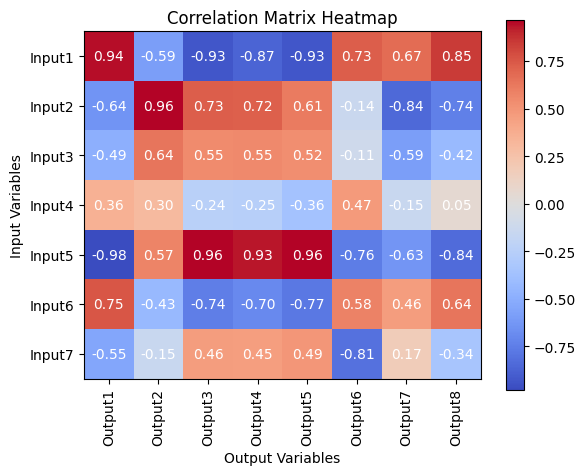

In [ ]:
correlation_matrix = np.corrcoef(test_features, y_pred, rowvar=False)[:7, 7:]

input_columns = ['melody', 'articulation', 'rhythm_complexity', 'rhythm_stability', 'dissonance', 'atonality', 'mode']
output_columns = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']

# Create a heatmap of the correlation matrix
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
rows, cols = correlation_matrix.shape
for i in range(rows):
    for j in range(cols):
        text = f"{correlation_matrix[i, j]:.2f}"
        plt.text(j, i, text, ha='center', va='center', color='white')
plt.xticks(range(cols), output_columns, rotation='vertical')
plt.yticks(range(rows), input_columns)

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Output Variables')
plt.ylabel('Input Variables')
plt.show()

## Cross Validation k = 5

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
feature_matrix_test = np.asarray(feature_matrix).astype(float)
label_matrix_test = np.asarray(label_matrix).astype(float)
corr_k = []
def relu_with_min(output):
    return tf.keras.backend.maximum(output, 1)

normalization_layer = layers.Normalization()
normalization_layer.adapt(train_features)

opt = keras.optimizers.Adam(learning_rate=0.008)

model = tf.keras.models.Sequential([
    normalization_layer,
    tf.keras.layers.Dense(8, activation=relu_with_min),
    # tf.keras.layers.Dense(8),
])
input_columns = ['melody', 'articulation', 'rhythm_complexity', 'rhythm_stability', 'dissonance', 'atonality', 'mode']
output_columns = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']
k = 6
kf = KFold(n_splits=k, shuffle=True)

initial_weights = model.get_weights()

for train_index, val_index in kf.split(feature_matrix_test):

  X_train, X_val = feature_matrix_test[train_index], feature_matrix_test[val_index]
  y_train, y_val = label_matrix_test[train_index], label_matrix_test[val_index]

  model.set_weights(initial_weights)
  model.compile(optimizer=opt, loss='MSE',  metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae', 'mape', 'accuracy'])
  model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE)

 
  y_pred = model.predict(X_val)
  correlation_matrix = np.corrcoef(X_val, y_val, rowvar=False)[:7, 7:]
  corr_k.append(correlation_matrix)

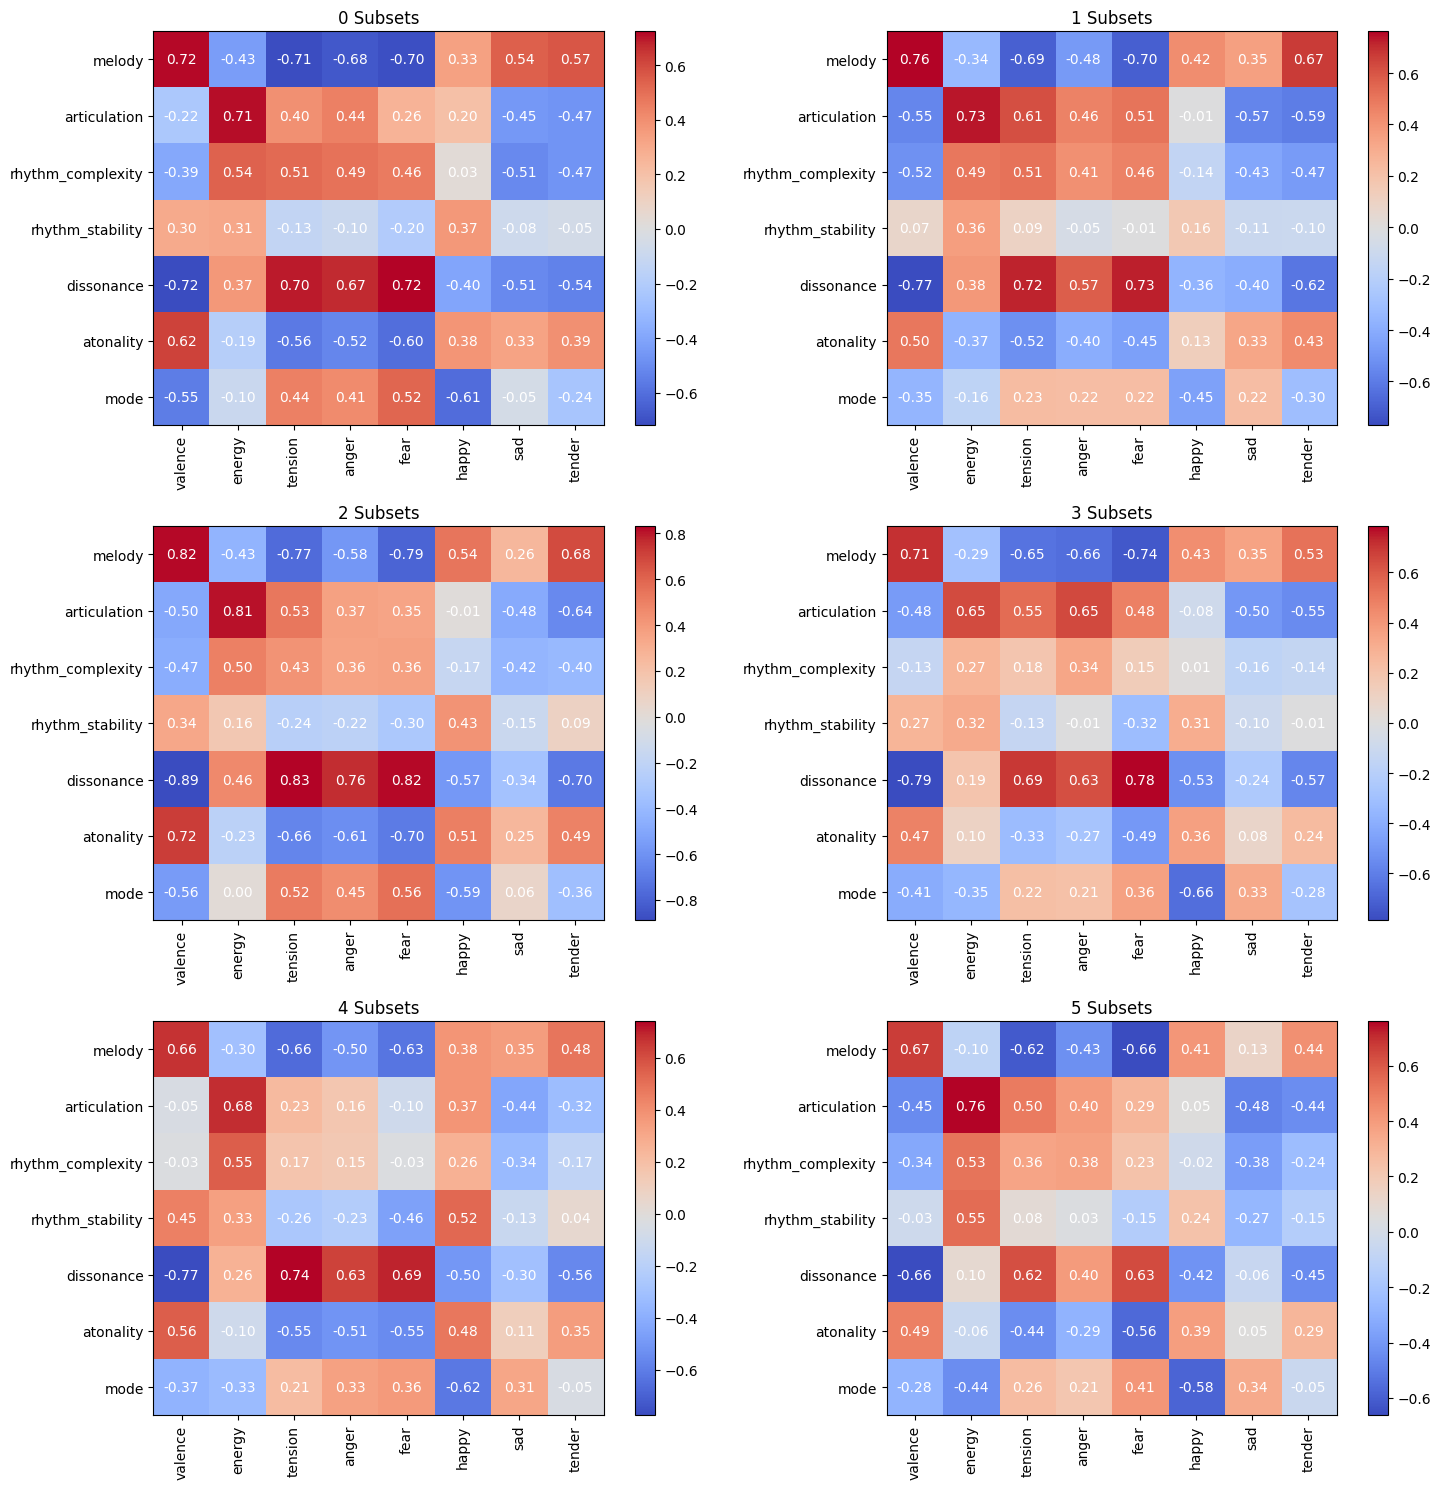

In [ ]:
input_columns = ['melody', 'articulation', 'rhythm_complexity', 'rhythm_stability', 'dissonance', 'atonality', 'mode']
output_columns = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']

r = len(corr_k)//2 + (1 if len(corr_k)%2 != 0 else 0) 
figure, axis = plt.subplots(r, 2, figsize=(15, 15))

for x in range(0,len(corr_k)):
  
  correlation_matrix = corr_k[x]
  y = x//2
  # print(y)
  if x % 2 == 0:
    ax = axis[y, 0]
  else:
    ax = axis[y, 1]
  # ax.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
  plt.colorbar(ax.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest'), ax=ax)
  # ax.colorbar()
# Create a heatmap of the correlation matrix

  rows, cols = correlation_matrix.shape
  for i in range(rows):
      for j in range(cols):
          text = f"{correlation_matrix[i, j]:.2f}"
          ax.text(j, i, text, ha='center', va='center', color='white')
  ax.set_xticks(range(cols), output_columns, rotation='vertical')
  # ax.xaxis.set_label_position('top') 
  ax.set_title(str(x) + ' Subsets')
  ax.set_yticks(range(rows), input_columns)
figure.tight_layout()
plt.show()

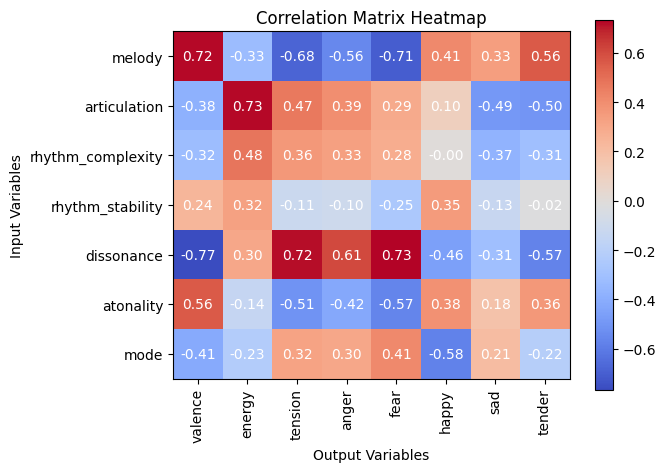

In [ ]:
correlation_matrix = np.corrcoef(feature_matrix_test, label_matrix_test, rowvar=False)[:7, 7:]

input_columns = ['melody', 'articulation', 'rhythm_complexity', 'rhythm_stability', 'dissonance', 'atonality', 'mode']
output_columns = ['valence', 'energy', 'tension', 'anger', 'fear', 'happy', 'sad', 'tender']

# Create a heatmap of the correlation matrix
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
rows, cols = correlation_matrix.shape
for i in range(rows):
    for j in range(cols):
        text = f"{correlation_matrix[i, j]:.2f}"
        plt.text(j, i, text, ha='center', va='center', color='white')
plt.xticks(range(cols), output_columns, rotation='vertical')
plt.yticks(range(rows), input_columns)

plt.title('Correlation Matrix Heatmap')
plt.xlabel('Output Variables')
plt.ylabel('Input Variables')
plt.show()